<h1> Particle Swarm Optimization </h1>

n_particles : INT  
w : regularize momentum FLOAT ( recommend .5 ~ 1.5 )  
alpha : upper bound of regularizing particle fitness FLOAT ( recommend .5 ~ 2 )    
beta : upper boudn of regularizing swarm fitness FLOAT ( recommanad 1 ~ 2.5 )  
random_state : INT  
search_space : DICT ex) a = {'a' : [1, 4], 'b' : [2, 6]}

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import matplotlib.animation as animation
from tqdm import trange

In [2]:
class PSO(object):
    def __init__(self, search_space, n_particles:int, alpha:float, beta:float, w:float,random_state = None):
        self.n_particles = n_particles
        self.w = w
        self.alpha = alpha
        self.beta = beta
        self.search_space = search_space
        self.fit = np.zeros(n_particles)
        self.random_state = random_state
        self.search_keys_ = list(search_space.keys())
                                  
                                
    def optimize(self, objective, n_iteration:int, opt_dir:str):
        assert (opt_dir == 'minimize')|(opt_dir == 'maximize')
        rgen = np.random.RandomState(self.random_state)
        self.p_ = np.column_stack([rgen.uniform(low = search_space[f'{x}'][0], high = search_space[f'{x}'][1], size = self.n_particles) for x in self.search_keys_])
        self.v_ = np.column_stack([rgen.normal(loc = 0., scale = .1, size = self.n_particles) for _ in range(len(self.search_keys_))])
        self.opt_dir = opt_dir
        self.n_iteration = n_iteration
        alpha = rgen.uniform(low = 0, high = self.alpha, size = self.n_particles)
        beta = rgen.uniform(low = 0, high = self.beta, size = self.n_particles)
        self.history_ = []
        self.res_ = []
        
        if self.opt_dir == 'minimize':
            self.f_ = np.array([np.Inf for _ in range(self.n_particles)])
            self.f_g_ = np.Inf
        if self.opt_dir == 'maximize':
            self.f_ = np.array([-(np.Inf) for _ in range(self.n_particles)])
            self.f_g_ = -(np.Inf)
        self.f_p_ = self.p_    
        
        
        for _ in trange(self.n_iteration):
            #step 1. compute fitness of each particles and update best fitness of each particles and swarm
            self.p_ = np.column_stack([np.clip(self.p_[:,x], a_min = self.search_space[f'{self.search_keys_[0]}'][0], a_max = self.search_space[f'{self.search_keys_[0]}'][1]) for x in range(len(self.search_keys_))])
            self.history_.append(self.p_)
            res = np.apply_along_axis(objective, axis = 1, arr = self.p_).reshape(self.n_particles, )
            self.res_.append(res)
            if self.opt_dir == 'minimize':
                bool_ = res < self.f_
                self.f_ = np.where(bool_, res, self.f_)
                self.f_p_ = np.column_stack([np.where(bool_, res, self.f_p_[:,x]) for x in range(len(self.search_keys_))])
                if self.f_g_ > np.min(self.f_):
                    self.f_g_ = np.min(self.f_)
                    self.f_g_p_ = self.p_[np.argmin(self.f_)]       
            if self.opt_dir == 'maximize':
                bool_ = res > self.f_
                self.f_ = np.where(bool_, res, self.f_)
                self.f_p_ = np.column_stack([np.where(bool_, res, self.f_p_[:,x]) for x in range(len(self.search_keys_))])
                if self.f_g_ < np.max(self.f_):
                    self.f_g_ = np.max(self.f_)
                    self.f_g_p_ = self.p_[np.argmax(self.f_)]   
            
            #step 2. adjust velocity
            alpha = rgen.uniform(low = 0, high = self.alpha, size = self.n_particles)
            beta = rgen.uniform(low = 0, high = self.beta, size = self.n_particles)
            self.v_ = (self.w * self.v_) + (alpha * (self.f_p_ - self.p_).T).T + (beta * (self.f_g_p_ - self.p_).T).T
            
            #step 3. update position: P = P + V
            p_ = self.p_
            self.p_ = self.p_ + self.v_
            
            #If particles don't move anymore, early stop optimization
            if np.all(self.p_ == p_):
                print(f'Optimization result :')
                print([f'{self.search_keys_[x]} : {self.f_g_p_[x]}' for x in range(len(self.search_keys_))])
                return self
            
            
        print(f'Optimization result :')
        print([f'{self.search_keys_[x]} : {self.f_g_p_[x]}' for x in range(len(self.search_keys_))])
        return self
            

In [3]:
def objective2(X):
    return (X[0]**2) + ((X[1] + 1)**2) - 5*(np.cos(X[0] + 1.5)) - 3*(np.cos((2*X[0]) - 1.5))

search_space = {'a' : [-7,7], 'b' : [-7,7]}
pso = PSO(n_particles = 50, search_space = search_space, alpha = .2, beta = 1.5, random_state = 42, w = .5)

In [4]:
pso.optimize(objective = objective2, n_iteration = 500, opt_dir = 'minimize')

100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1649.16it/s]

Optimization result :
['a : -1.841303825643454', 'b : -0.998111669824552']


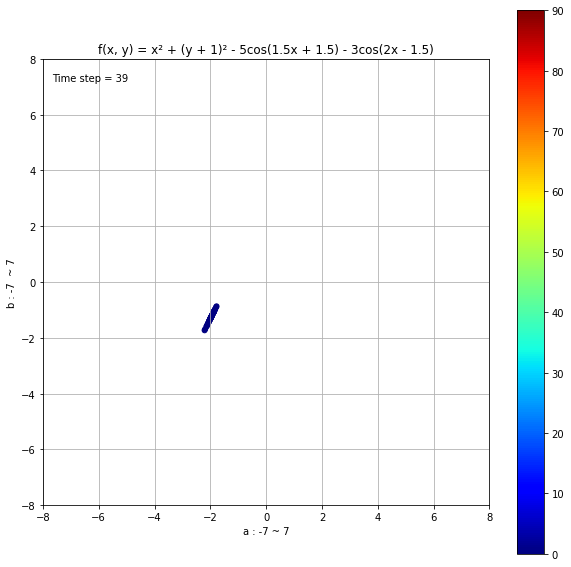

In [5]:
time_steps = 40
N_nodes = 50

fig, ax = plt.subplots(figsize = (10, 10))
marker_size = 25 #upped this to make points more visible


def animate(i):
    """ Perform animation step. """
    #important - the figure is cleared and new axes are added
    fig.clear()
    ax = fig.add_subplot(111, aspect='equal', autoscale_on=False, xlim=(-8,8), ylim=(-8,8))
    #the new axes must be re-formatted
    ax.set_xlim(-8,8)
    ax.set_ylim(-8,8)
    ax.grid(b=None)
    ax.set_xlabel(f'{pso.search_keys_[0]} : {pso.search_space[pso.search_keys_[0]][0]} ~ {pso.search_space[pso.search_keys_[0]][1]}')
    ax.set_ylabel(f'{pso.search_keys_[1]} : {pso.search_space[pso.search_keys_[1]][0]}  ~ {pso.search_space[pso.search_keys_[1]][1]}')
    # and the elements for this frame are added
    ax.text(0.02, 0.95, 'Time step = %d' % i, transform=ax.transAxes)
    ax.set_title('f(x, y) = x² + (y + 1)² - 5cos(1.5x + 1.5) - 3cos(2x - 1.5)')
    s = ax.scatter(pso.history_[i][:,0], pso.history_[i][:,1], s = marker_size, c = pso.res_[i], cmap = plt.cm.jet, marker = "o", edgecolor = None, vmin = 0, vmax = 90)
    fig.colorbar(s)

ani = animation.FuncAnimation(fig, animate, interval=150, frames=range(time_steps))

ani.save('ParticleSwarmOptimization_onlylocation.gif', writer='pillow')

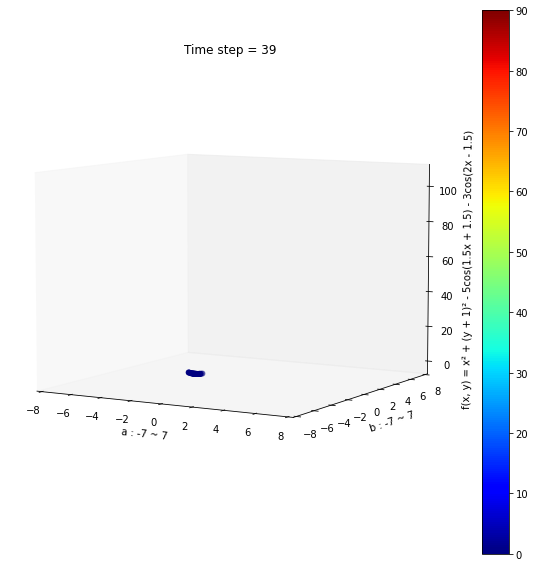

In [6]:
time_steps = 40
N_nodes = 50


fig, ax = plt.subplots(figsize = (10, 10))
marker_size = 25 #upped this to make points more visib

def animate(i):
    fig.clear()
    ax = fig.add_subplot(111, projection = '3d')
    ax.set_xlim(-8,8)
    ax.set_ylim(-8,8)
    ax.set_zlim(-5,110)
    ax.view_init(7, -60)
    ax.grid(b = None)
    ax.set_title('Time step = %d' % i)
    ax.set_xlabel(f'{pso.search_keys_[0]} : {pso.search_space[pso.search_keys_[0]][0]} ~ {pso.search_space[pso.search_keys_[0]][1]}')
    ax.set_ylabel(f'{pso.search_keys_[1]} : {pso.search_space[pso.search_keys_[1]][0]} ~ {pso.search_space[pso.search_keys_[1]][1]}')
    ax.set_zlabel('f(x, y) = x² + (y + 1)² - 5cos(1.5x + 1.5) - 3cos(2x - 1.5)')
    s = ax.scatter(pso.history_[i][:,0], pso.history_[i][:,1], pso.res_[i], s = marker_size, c = pso.res_[i], cmap = plt.cm.jet, marker = 'o', edgecolor = None, vmin = 0, vmax = 90)
    fig.colorbar(s)
    
ani = animation.FuncAnimation(fig, animate, interval=150, frames=range(time_steps))

ani.save('ParticleSwarmOptimization_includefit.gif', writer='pillow')